In [12]:
from PIL import Image
import glob
import random
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [13]:
image_path = '/home/mila/v/venkatesh.ramesh/scratch/tree_data/final_dataset/splits/train/labels/22'

images_list = glob.glob(image_path + '/**/*.png', recursive=True)

### Function to stich tiles

In [18]:
def stich_tile(img, size):
    """
    Input: 
    img -> Image file path
    size -> Size of the resulting image. An odd multiple of of 256 so 
            that (0, 0) tile is the centre of the stiched image.
            
    Returns:
    result -> Stiched Image
    """
    base_size = 256
    
    splits = img.split('/')
    z, x, y = splits[-3], splits[-2], splits[-1].split('.')[0]
    
    result = Image.new('RGB', (size, size), color=0)
    
    i_count = 0
    j_count = 0
    
    assert (size//base_size) % 2 != 0, "Size should be an odd multiple of of 256 so that (0, 0) tile is the centre of the stiched image."
    # To loop from -i to i centered around 0. Might be a more elegant way to do this?
    loop_range = int((size//base_size)/2)
    
   
    
    for i in range(-loop_range, loop_range+1, 1):
        
        j_count = 0
        for j in range(-loop_range, loop_range+1, 1):
            try:
                temp_img = Image.open(os.path.join(image_path, str(int(x)+i), str(int(y)+j)+'.png'))           
            except:
                temp_img = Image.new('RGB', (base_size, base_size), color=0)
                
            result.paste(im=temp_img, box=(i_count*base_size, j_count*base_size))
            
            j_count += 1
        i_count += 1
        
    return result

### Get min,max of x and y

In [15]:
random.shuffle(images_list)

counter = 0
for img in tqdm(images_list):
    splits = img.split('/')
    _, x, y = splits[-3], splits[-2], splits[-1].split('.')[0]
    
    x, y = int(x), int(y)
    
    if counter == 0:
        min_x, min_y = x, y
        max_x, max_y = x, y
        
    counter += 1
    
    min_x = x if x < min_x else min_x
    min_y = y if y < min_y else min_y
    
    max_x = x if x > max_x else max_x
    max_y = y if y > max_y else max_y

100%|██████████| 9544/9544 [00:00<00:00, 475856.04it/s]


In [16]:
print(min_x, min_y, max_x, max_y)

1234870 1492252 1234961 1492394


### Append values in the frequency matrix

In [19]:
frequency_matrix = np.zeros((31, 31))

for x in tqdm(range(min_x, max_x+1, 3)): # Step size 3x3 for image size 768*768
    for y in range(min_y, max_y+1, 3):
        
        img_file = os.path.join(image_path, str(int(x)), str(int(y))+'.png')
        img = stich_tile(img_file, 768)
        
        img_int = (np.array(img)/10).astype('uint8') # 10 is the multiplication factor for the mask
        unq_classes = np.unique(img_int)
        
        unq_classes.sort()
        
        if len(unq_classes) > 1:
            unq_nonzero = np.delete(unq_classes, 0) # Remove background class
            
            for cls1 in unq_nonzero:
                    for cls2 in unq_nonzero:
                        frequency_matrix[cls1-1][cls2-1] += 1 #cls-1 because 0 is background and cls index are from 1-22 apart from background

100%|██████████| 31/31 [01:02<00:00,  2.02s/it]


### Plot lower diagonal frequency map

In [20]:
def get_lower_tri_heatmap(df):
    mask = np.zeros_like(df, dtype=bool)
    
    # Remove upper triangle elemenents
    mask[np.triu_indices_from(mask)] = True

    # Don't want diagonal elements 
    mask[np.diag_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(200, 0, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    
    # Load classes json
    f = open('/home/mila/v/venkatesh.ramesh/scratch/tree_data/labels/classes.json')
    json_data = json.load(f)
    class_list = list(json_data.keys())
    f.close()
    
    sns_plot = sns.heatmap(df, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            xticklabels=class_list, yticklabels=class_list)
    # save to file
    fig = sns_plot.get_figure()
#     fig.savefig(output)
    return fig

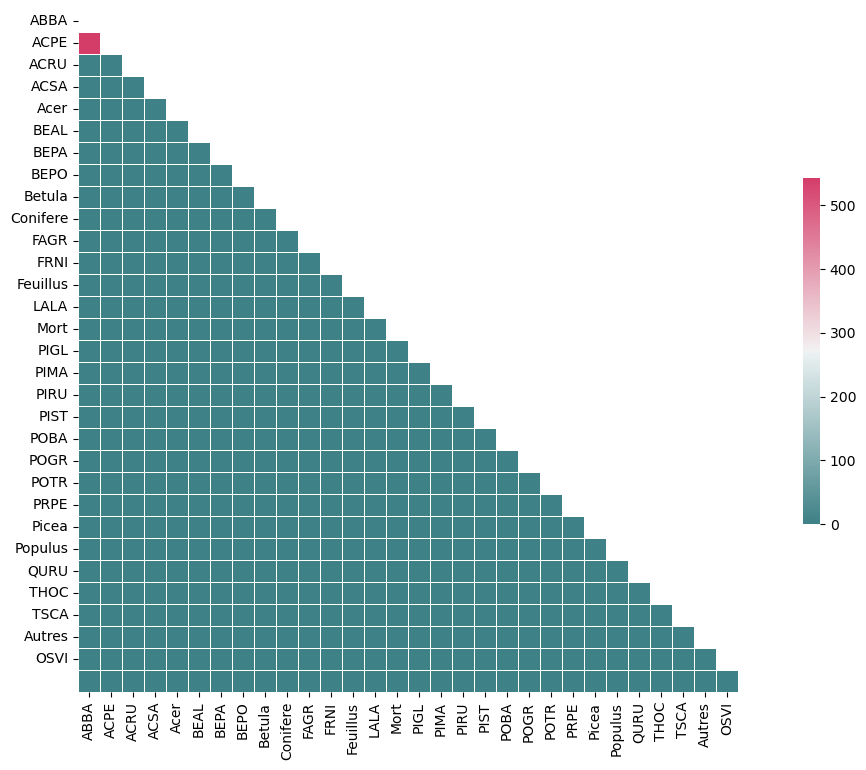

In [22]:
fig = get_lower_tri_heatmap(frequency_matrix)

### Count class-wise pixels in the dataset

In [8]:
pixel_frequency = np.zeros((31, 1))

for img in tqdm(images_list):
    
    img_int = (np.array(Image.open(img))).astype('uint8') # 10 is the multiplication factor for the mask
    unq_classes, val_counts = np.unique(img_int, return_counts=True)
    
    for label, count in zip(unq_classes, val_counts):
        if label <= 30:
            pixel_frequency[label] += count

100%|██████████| 9544/9544 [00:30<00:00, 315.62it/s]


In [ ]:
pixel_frequency

In [ ]:
unq_classes

In [ ]:
val_counts